In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# **sample data only contains 3 images | Add your images to train the model**

In [6]:
!unzip -q ./sample.zip -d ./

# **MODEL ARCHITECTURE**

In [ ]:
f_shape = 280
input = layers.Input((f_shape,f_shape,1))
s = layers.Conv2D(64,(2,2),activation='relu',padding='same')(input)
####
v = layers.Conv2D(64,(4,8),activation='relu',padding='same')(s)
v = layers.Conv2D(64,(3,6),activation='relu',padding='same')(v)
v = layers.Conv2D(64,(2,4),activation='relu',padding='same')(v)
v=  layers.Dropout(0.3)(v)

####
h = layers.Conv2D(64,(8,4),activation='relu',padding='same')(s)
h = layers.Conv2D(64,(6,3),activation='relu',padding='same')(h)
h = layers.Conv2D(64,(4,2),activation='relu',padding='same')(h)
h=  layers.Dropout(0.3)(h)
####
xb = layers.Conv2D(64,(4,4),activation='relu',padding='same')(s)
xb = layers.Conv2D(128,(4,4),activation='relu',padding='same',strides=(2,2))(xb)
xb=  layers.Dropout(0.3)(xb)
xb = layers.Conv2DTranspose(128,(4,4),activation='relu',padding='same',strides=(2,2))(xb)
b = layers.concatenate([v,h,xb])
b=  layers.Dropout(0.3)(b)
b = layers.Conv2D(128,(4,4),activation='relu',padding='same',strides=(2,2))(b)
b = layers.Conv2DTranspose(32,(4,4),activation='relu',padding='same',strides=(2,2))(b)
b=  layers.Dropout(0.3)(b)

####
x = layers.concatenate([v,h,b,xb,s,input])
b=  layers.Dropout(0.3)(b)
x = layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = layers.concatenate([x,s,input])
x = layers.Conv2D(1,(2,2),activation='sigmoid',padding='same')(x)
###########
model = Model(inputs=input,outputs=x)
model.compile(optimizer='Adam',loss='mean_squared_error',metrics=['mean_absolute_error'])
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True,rankdir='LR')


# **GENERATE DATA**

In [8]:
data_dir = '/content/sample/'
data_quantity = 1.0 # range 0-1 
gaussian_kernel_size_list = [1,3,5] # odd numbers | used for gaussian blur

normal_res = []
low_res = []
kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 
data = os.listdir(data_dir)
np.random.shuffle(data)
data = data[:int(len(data)*data_quantity)]
ss = []
for i in tqdm(data):
  img = cv2.imread(data_dir+i,0)
  h,w = img.shape[:2]
  img = cv2.normalize(img,np.zeros((h,w)),0,255,cv2.NORM_MINMAX)
  nh = (f_shape*2)
  nw = int((nh/h)*w)
  img = cv2.resize(img,(nw,nh),interpolation=cv2.INTER_AREA)
  pad_x = (f_shape-nw%f_shape)
  pad = np.zeros((nh,pad_x)).astype(np.uint8)
  final_img = np.hstack([img,pad])
  fh,fw = final_img.shape
  for y in range(fh//f_shape):
    for x in range(fw//f_shape):
        g = final_img[int(y*f_shape):int((y+1)*f_shape),int(x*f_shape):int((x+1)*f_shape)]
        g = cv2.normalize(g,np.zeros(g.shape),0,255,cv2.NORM_MINMAX)
        if (g==0).sum()>f_shape*f_shape*0.3:
          continue
        ng = cv2.resize(g,(f_shape*2,f_shape*2),interpolation=cv2.INTER_CUBIC)
        ng = cv2.GaussianBlur(ng,(3,3),0)
        ng = cv2.filter2D(ng, -1, kernel)
        g = cv2.resize(ng,(f_shape,f_shape),interpolation=cv2.INTER_CUBIC)
        normal_res.append(np.array([g/255]).reshape(f_shape,f_shape,1))
        intts = [cv2.INTER_AREA,cv2.INTER_CUBIC,cv2.INTER_LANCZOS4,cv2.INTER_LINEAR]
        intt = np.random.choice(intts)
        kh = np.random.choice(gaussian_kernel_size_list)
        kv = np.random.choice(gaussian_kernel_size_list)
        g = cv2.GaussianBlur(g,(kh,kv),0)
        s = np.random.randint(f_shape*0.6,f_shape*0.9)
        g = cv2.resize(g,(s,s),interpolation=intt)
        g = cv2.resize(g,(f_shape,f_shape),interpolation=intt)
        g = cv2.normalize(g,np.zeros(g.shape),0,255,cv2.NORM_MINMAX)
        low_res.append(np.array([g/255]).reshape(f_shape,f_shape,1))

low_res = np.array(low_res)
normal_res = np.array(normal_res)
print(low_res.shape,normal_res.shape)

100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

(10, 280, 280, 1) (10, 280, 280, 1)


# **TRAIN TEST SPLIT**

In [9]:
from sklearn.model_selection import train_test_split
xtr,xt,ytr,yt = train_test_split(low_res,normal_res,test_size=0.2)

# **VISUALIZE GENERATED DATA AND CHANGE GENERATOR CODE PARAMETERS IF DATA LOOKS FAKE OR NOT USABLE AT ALL**

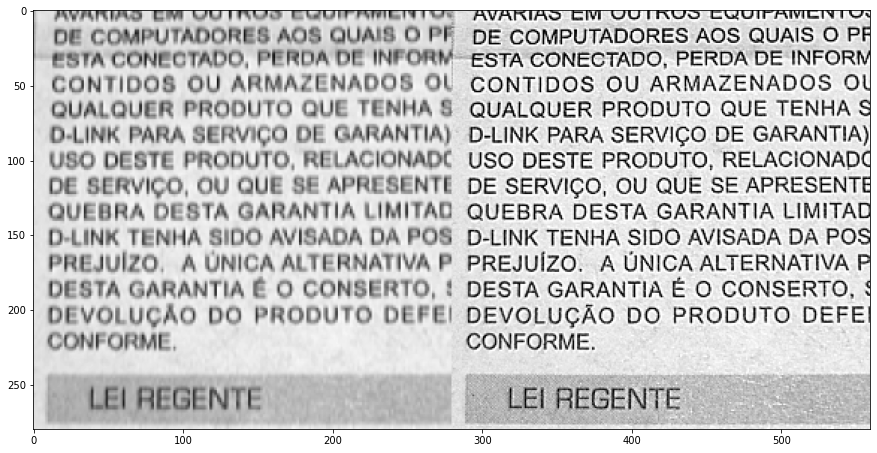

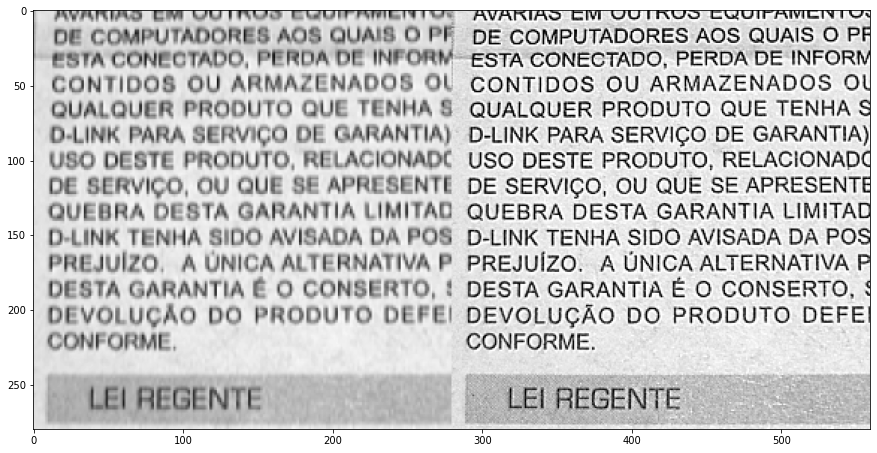

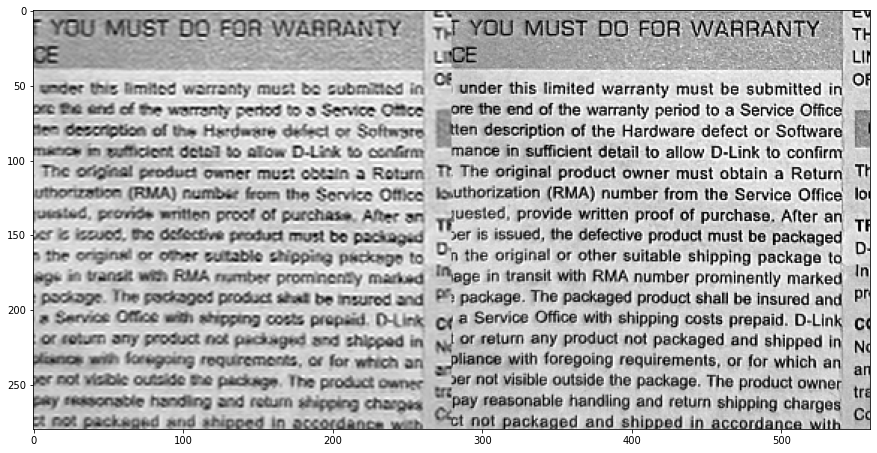

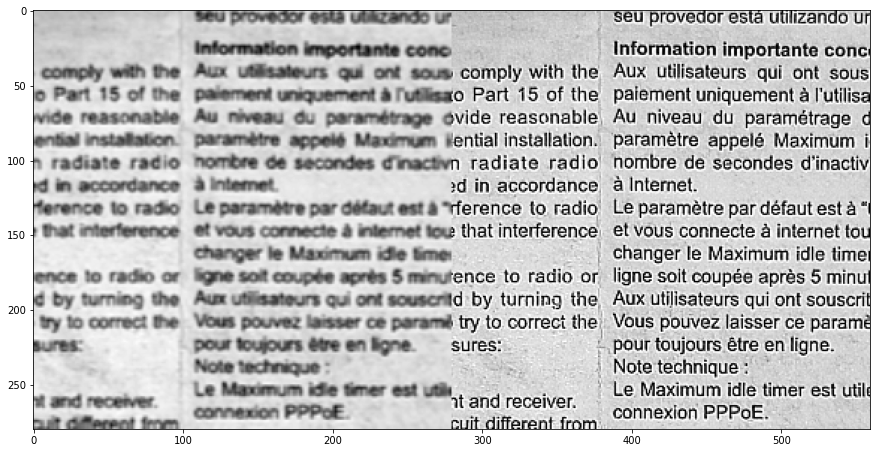

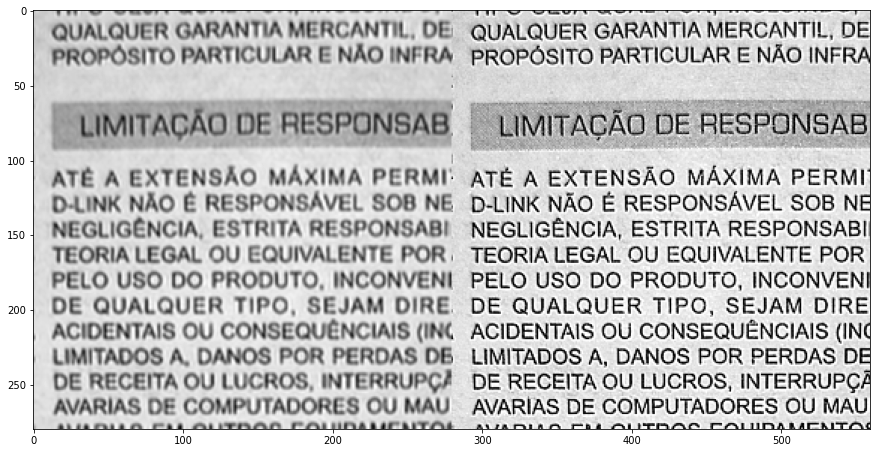

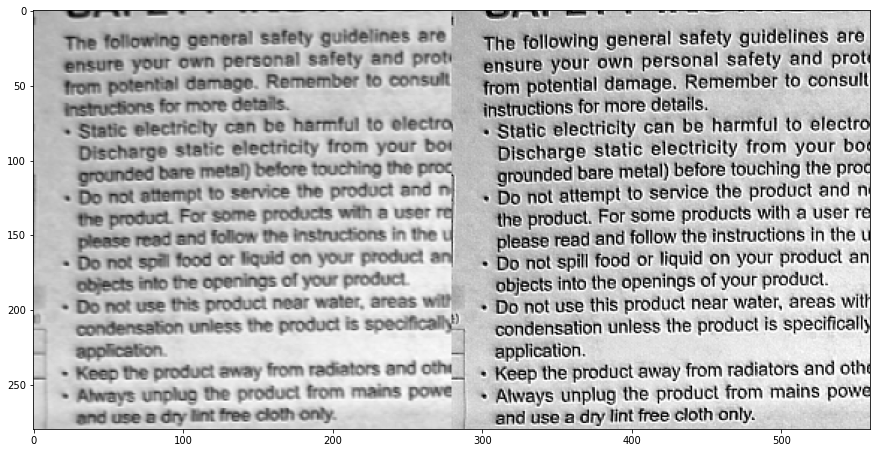

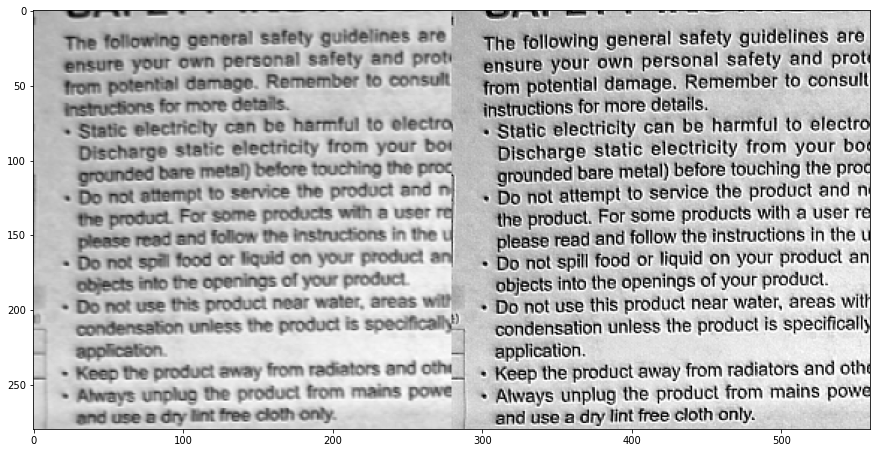

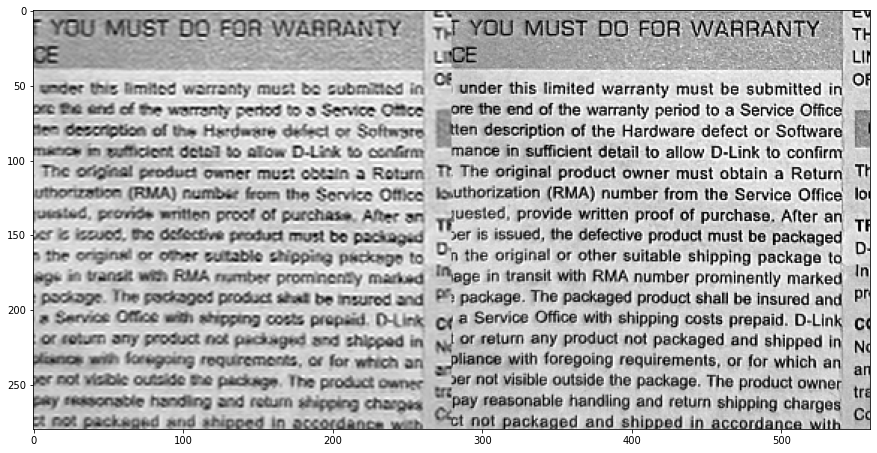

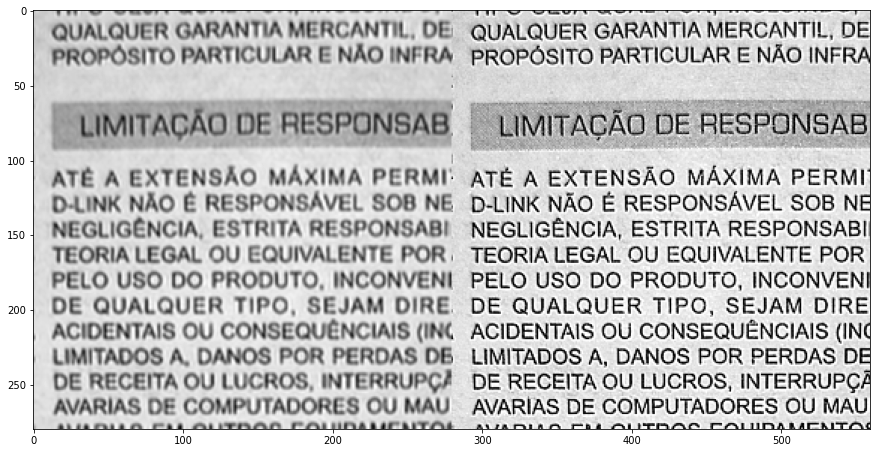

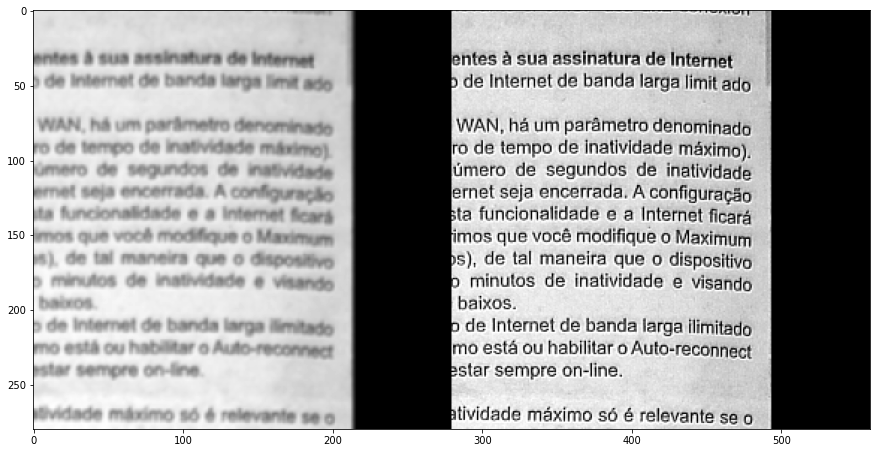

In [10]:
for i in range(10):
  i = np.random.randint(0,len(ytr))
  n,l = xtr[i],ytr[i]
  plt.figure(figsize=(15,15))
  i = np.hstack([n[:,:,0],l[:,:,0]])
  plt.imshow(i,cmap='gray')
  plt.show()

In [11]:
print(xtr.shape)
print(xtr.shape)
print(xt.shape)
print(xt.shape)

(8, 280, 280, 1)
(8, 280, 280, 1)
(2, 280, 280, 1)
(2, 280, 280, 1)


# TRAIN THE **MODEL**

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

checkpoint = ModelCheckpoint(filepath='./mbm.h5', 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

model.fit(xtr,ytr,batch_size=16,epochs=300,validation_data=(xt,yt),callbacks=callbacks)
model.save('mlm.h5')

Epoch 1/300
1/1 [==============================] - 30s 30s/step - loss: 0.1205 - mean_absolute_error: 0.3251 - val_loss: 0.1063 - val_mean_absolute_error: 0.3009
Epoch 2/300
1/1 [==============================] - 2s 2s/step - loss: 0.0930 - mean_absolute_error: 0.2739 - val_loss: 0.0822 - val_mean_absolute_error: 0.2088
Epoch 3/300
1/1 [==============================] - 2s 2s/step - loss: 0.0763 - mean_absolute_error: 0.1935 - val_loss: 0.0848 - val_mean_absolute_error: 0.1851
Epoch 4/300
1/1 [==============================] - 2s 2s/step - loss: 0.0824 - mean_absolute_error: 0.1820 - val_loss: 0.0810 - val_mean_absolute_error: 0.2140
Epoch 5/300
1/1 [==============================] - 2s 2s/step - loss: 0.0743 - mean_absolute_error: 0.1964 - val_loss: 0.0867 - val_mean_absolute_error: 0.2512
Epoch 6/300
1/1 [==============================] - 2s 2s/step - loss: 0.0767 - mean_absolute_error: 0.2274 - val_loss: 0.0837 - val_mean_absolute_error: 0.2405
Epoch 7/300
1/1 [=====================

# **CHECK THE PREDICTIONS ON VALIDATION DATA**

In [ ]:
yp = model.predict(xt[0:10])
for n,l in zip(xt[0:10],yp[:10]):
  plt.figure(figsize=(40,40))
  i = np.hstack([n[:,:,0],l[:,:,0]])
  plt.imshow(i,cmap='gray')
  plt.show()

# **FINAL PREDICT FUNCTION TO USE THE MODEL ON REAL SIZE IMAGES**

In [14]:
def predict(img,f_shape,y_block=2): #final_height will be f_shape*y_block
  h,w = img.shape[:2]
  img = cv2.normalize(img,np.zeros((h,w)),0,255,cv2.NORM_MINMAX)
  nh = (f_shape*y_block)
  nw = int((nh/h)*w)
  img = cv2.resize(img,(nw,nh),interpolation=cv2.INTER_AREA)
  pad_x = (f_shape-nw%f_shape)
  pad = np.zeros((nh,pad_x)).astype(np.uint8)
  final_img = np.hstack([img,pad])
  fh,fw = final_img.shape
  print(fh/f_shape,fw/f_shape,'Total Block/Grids : ',(fh/f_shape)*(fw/f_shape))
  grids = []
  for y in range(fh//f_shape):
    for x in range(fw//f_shape):
        g = final_img[int(y*f_shape):int((y+1)*f_shape),int(x*f_shape):int((x+1)*f_shape)]
        grids.append(np.array([g/255]).reshape(f_shape,f_shape,1))
  grids = np.array(grids)
  ops = model.predict(grids)
  opimg = np.zeros((fh,fw)).astype(np.uint8)
  c=0
  for y in range(fh//f_shape):
    for x in range(fw//f_shape):
        opimg[int(y*f_shape):int((y+1)*f_shape),int(x*f_shape):int((x+1)*f_shape)] = (ops[c,:,:,0]*255).astype(np.uint8)
        c+=1
  opimg = opimg[:,:-pad_x]
  return opimg

In [17]:
r = cv2.imread('/content/x.jpg',0)
op = predict(r,f_shape,y_block=2)

2.0 4.0 Total Block/Grids :  8.0


In [ ]:
plt.figure(figsize=(40,40))
plt.imshow(r,cmap='gray')
plt.show()
plt.figure(figsize=(40,40))
plt.imshow(op,cmap='gray')
plt.show()